In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, plot_roc_curve, recall_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv('data/weatherAUS.csv')
df.head()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df.dropna(subset = ['RainTomorrow'], inplace = True)

In [ ]:
df.drop(columns = 'Evaporation', inplace=True)

In [ ]:
df_nums = df.select_dtypes('float64')
df_nums.head()

In [ ]:
df_nums.describe()

In [ ]:
df2 = df_nums.copy()

In [ ]:
df2[(np.abs(stats.zscore(df2)) < 3).all(axis=1)]

In [ ]:
df_test = df2.drop(columns=['Cloud9am', 'Cloud3pm'])
df_test.head()

In [ ]:
features = df_test.columns
for feature in features:
    qupper = df_test[feature].quantile(0.99)
    print(feature, len(df_test.loc[df_test[feature] < qupper]))

In [ ]:
features = df_test.columns
for feature in features:
    qupper = df_test[feature].quantile(0.99)
    df_test = df_test.loc[(df_test[feature].isna()) | (df_test[feature] < qupper)]

In [ ]:
df_test.describe()

In [ ]:
df_test.isna().sum()

In [ ]:
df_test.drop(columns =['Evaporation', 'Sunshine'], axis = 1, inplace=True)

In [ ]:
df_test.describe()

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights="uniform")
imputed = imputer.fit_transform(df_test)
df_imputed = pd.DataFrame(imputed, index = df_test.index)

In [ ]:
df_imputed.describe()

In [ ]:
df_imputed.isna().sum()

In [ ]:
df_imputed

In [ ]:
df.Humidity9am.plot.hist()

In [ ]:
df.MaxTemp.plot.hist()

In [ ]:
df.Rainfall.plot.hist()

In [2]:
X_train_KNNI = pd.read_csv("data/X_train_KNNI.csv", index_col=0)
X_test_KNNI = pd.read_csv("data/X_test_KNNI.csv", index_col=0)
y_test = pd.read_csv("data/y_test.csv", index_col=0)
y_train = pd.read_csv("data/y_train.csv", index_col=0)

In [4]:
X_train_KNNI.to_parquet('X_train_KNNI.parquet', compression=None)

In [5]:
X_test_KNNI.to_parquet('X_test_KNNI.parquet', compression=None)

In [6]:
y_test.to_parquet('y_test.parquet', compression=None)

In [7]:
y_train.to_parquet('y_train.parquet', compression=None)

In [ ]:
forest = RandomForestClassifier(max_depth=10, random_state=42)
forest.fit(X_train_KNNI, np.ravel(y_train))

In [ ]:
forest.score(X_train_KNNI, y_train)

In [4]:
def model_metrics(model, X_train, y_train, name):
    plot_confusion_matrix(model, X_train, y_train, cmap='rocket');
    plot_roc_curve(model, X_train, y_train);
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    cv = cross_val_score(model, X_train, y_train)
    return print(f"""
    {name} Model Metrics:
    Accuracy Score: {accuracy}
    Recall Score: {recall}
    Precision Score: {precision}
    F1 Score: {f1}
    Cross Validation Scores: {cv}
    """)

In [ ]:
model_metrics(forest, X_train_KNNI, np.ravel(y_train), 'Rforest')

In [5]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_KNNI, y_train)

In [6]:
sm_forest = RandomForestClassifier(max_depth=11, min_samples_split=4, random_state=42)
sm_forest.fit(X_train_resampled, np.ravel(y_train_resampled))

RandomForestClassifier(max_depth=11, min_samples_split=4, random_state=42)


    SMRforest Model Metrics:
    Accuracy Score: 0.877235346064687
    Recall Score: 0.8812920852191191
    Precision Score: 0.8741992882562277
    F1 Score: 0.8777313580518373
    Cross Validation Scores: [0.7385905  0.85825658 0.89202801 0.89675394 0.89457707]
    


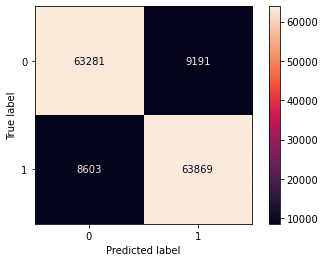

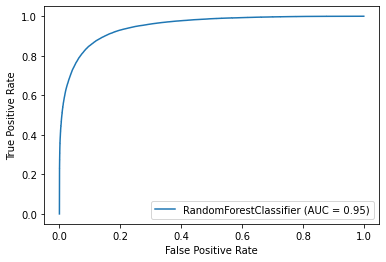

In [7]:
model_metrics(sm_forest, X_train_resampled, np.ravel(y_train_resampled), 'SMRforest')


    TestSMRforest Model Metrics:
    Accuracy Score: 0.8187735077677841
    Recall Score: 0.6554171266361772
    Precision Score: 0.553248136315229
    F1 Score: 0.6000144373059987
    Cross Validation Scores: [0.84349959 0.85134914 0.84922322 0.83924775 0.84578904]
    


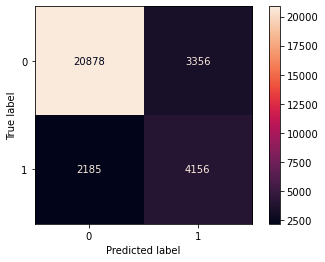

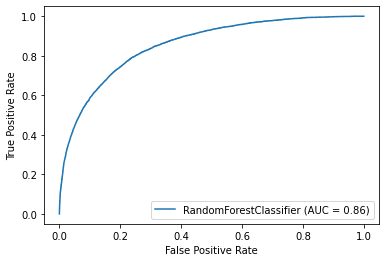

In [9]:
model_metrics(sm_forest, X_test_KNNI, np.ravel(y_test), 'TestSMRforest')

In [ ]:
forest = RandomForestClassifier()
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [8, 9, 10, 11], 'min_samples_split': [2, 4, 6]}
gs_sm_forest = GridSearchCV(forest, param_grid)
gs_sm_forest.fit(X_train_resampled, np.ravel(y_train_resampled))
gs_sm_forest.best_params_

In [11]:
forest = RandomForestClassifier()
param_grid = {'max_depth': [11, 12, 13], 'min_samples_split': [4, 5], 'min_samples_leaf': [1, 2, 3]}
gs_sm_forest = GridSearchCV(forest, param_grid)
gs_sm_forest.fit(X_train_KNNI, np.ravel(y_train))
gs_sm_forest.best_params_

{'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 5}

In [12]:
forest2 = RandomForestClassifier(max_depth=13, min_samples_split=5, random_state=42)
forest2.fit(X_train_KNNI, np.ravel(y_train))

RandomForestClassifier(max_depth=13, min_samples_split=5, random_state=42)

In [14]:
def model_metrics(model, X_train, y_train, X_test, y_test, name):
    
    # calculate training data metrics
    y_train_pred = model.predict(X_train)
    accuracy_train = round(accuracy_score(y_train, y_train_pred), 3)
    recall_train = round(recall_score(y_train, y_train_pred), 3)
    precision_train = round(precision_score(y_train, y_train_pred), 3)
    f1_train = round(f1_score(y_train, y_train_pred), 3)
    cv = round(cross_val_score(model, X_train, y_train).mean(), 3)
    
    # calculate test data metrics
    y_test_pred = model.predict(X_test)
    accuracy_test = round(accuracy_score(y_test, y_test_pred), 3)
    recall_test = round(recall_score(y_test, y_test_pred), 3)
    precision_test = round(precision_score(y_test, y_test_pred), 3)
    f1_test = round(f1_score(y_test, y_test_pred), 3)
    
    # print metrics
    print(f"""
    {name} Model Training Metrics:
    Accuracy Score: {accuracy_train}
    Recall Score: {recall_train}
    Precision Score: {precision_train}
    F1 Score: {f1_train}
    Cross Validation Score: {cv}
    ------
    {name} Model Test Metrics:
    Accuracy Score: {accuracy_test}
    Recall Score: {recall_test}
    Precision Score: {precision_test}
    F1 Score: {f1_test}
    """)
    
    # plot confusion matrices & roc curves
    print(f"{name} Model Training Confusion Matrix")
    plt.show(plot_confusion_matrix(model, X_train, y_train, cmap='rocket'))
    print(f"{name} Model Training ROC Curve")
    plt.show(plot_roc_curve(model, X_train, y_train))
    print(f"{name} Model Test Confusion Matrix")
    plt.show(plot_confusion_matrix(model, X_test, y_test, cmap='rocket'))
    print(f"{name} Model Test ROC Curve")
    plt.show(plot_roc_curve(model, X_test, y_test))

In [15]:
model_metrics(forest2, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'forest2')


    forest2 Model Training Metrics:
    Accuracy Score: 0.875
    Recall Score: 0.467
    Precision Score: 0.886
    F1 Score: 0.611
    Cross Validation Score: 0.847
    ------
    forest2 Model Test Metrics:
    Accuracy Score: 0.85
    Recall Score: 0.396
    Precision Score: 0.772
    F1 Score: 0.523
    
forest2 Model Training Confusion Matrix


AttributeError: module 'matplotlib' has no attribute 'show'

In [17]:
forest = RandomForestClassifier()
param_grid = {'max_depth': [13, 14, 15], 'min_samples_split': [5, 6, 7]}
gs_sm_forest = GridSearchCV(forest, param_grid)
gs_sm_forest.fit(X_train_KNNI, np.ravel(y_train))
gs_sm_forest.best_params_

{'max_depth': 15, 'min_samples_split': 6}

In [18]:
forest3 = RandomForestClassifier(max_depth=15, min_samples_split=6, random_state=42)
forest3.fit(X_train_KNNI, np.ravel(y_train))

RandomForestClassifier(max_depth=15, min_samples_split=6, random_state=42)


    forest3 Model Training Metrics:
    Accuracy Score: 0.89
    Recall Score: 0.526
    Precision Score: 0.915
    F1 Score: 0.668
    Cross Validation Score: 0.849
    ------
    forest3 Model Test Metrics:
    Accuracy Score: 0.852
    Recall Score: 0.415
    Precision Score: 0.763
    F1 Score: 0.537
    
forest3 Model Training Confusion Matrix


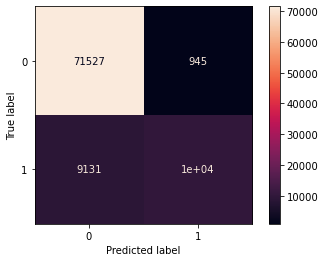

forest3 Model Training ROC Curve


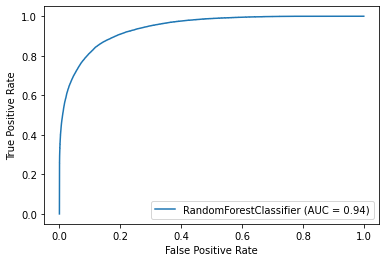

forest3 Model Test Confusion Matrix


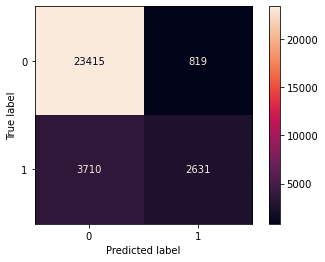

forest3 Model Test ROC Curve


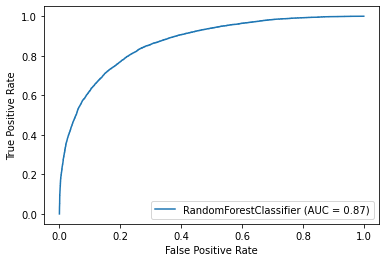

In [19]:
model_metrics(forest3, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'forest3')

In [20]:
forest = RandomForestClassifier(max_depth=13, min_samples_split=5, random_state=42)
param_grid = {'class_weight': ['balanced', 'balanced_subsample']}
gs_forest = GridSearchCV(forest, param_grid, verbose=2)
gs_forest.fit(X_train_KNNI, np.ravel(y_train))
gs_forest.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] class_weight=balanced ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ class_weight=balanced, total=   9.3s
[CV] class_weight=balanced ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV] ............................ class_weight=balanced, total=   9.5s
[CV] class_weight=balanced ...........................................
[CV] ............................ class_weight=balanced, total=   9.5s
[CV] class_weight=balanced ...........................................
[CV] ............................ class_weight=balanced, total=   9.2s
[CV] class_weight=balanced ...........................................
[CV] ............................ class_weight=balanced, total=   9.2s
[CV] class_weight=balanced_subsample .................................
[CV] .................. class_weight=balanced_subsample, total=  10.6s
[CV] class_weight=balanced_subsample .................................
[CV] .................. class_weight=balanced_subsample, total=  10.6s
[CV] class_weight=balanced_subsample .................................
[CV] .................. class_weight=balanced_subsample, total=  10.6s
[CV] class_weight=balanced_subsample .................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


{'class_weight': 'balanced_subsample'}

In [21]:
forest4 = RandomForestClassifier(min_samples_split=6, class_weight='balanced_subsample', random_state=42)
forest4.fit(X_train_KNNI, np.ravel(y_train))

RandomForestClassifier(class_weight='balanced_subsample', min_samples_split=6,
                       random_state=42)


    forest4 Model Training Metrics:
    Accuracy Score: 0.995
    Recall Score: 0.993
    Precision Score: 0.983
    F1 Score: 0.988
    Cross Validation Score: 0.852
    ------
    forest4 Model Test Metrics:
    Accuracy Score: 0.856
    Recall Score: 0.521
    Precision Score: 0.706
    F1 Score: 0.6
    
forest4 Model Training Confusion Matrix


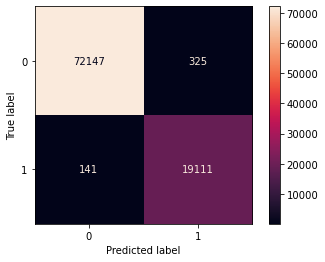

forest4 Model Training ROC Curve


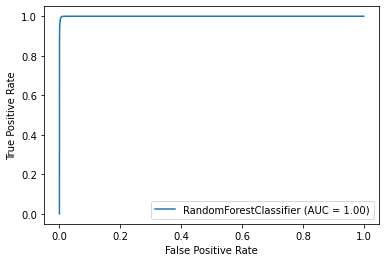

forest4 Model Test Confusion Matrix


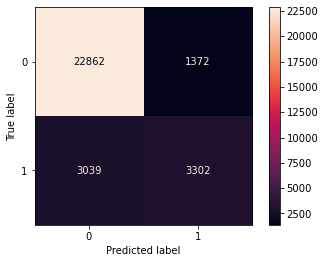

forest4 Model Test ROC Curve


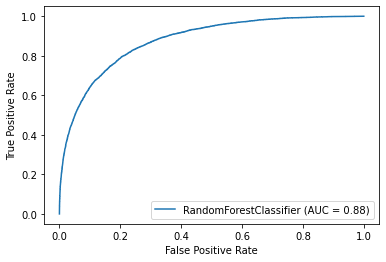

In [22]:
model_metrics(forest4, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'forest4')

In [28]:
forest5 = RandomForestClassifier(max_depth=10, n_estimators=200, min_samples_split=6, class_weight='balanced_subsample', random_state=42)
forest5.fit(X_train_KNNI, np.ravel(y_train))

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_split=6, n_estimators=200, random_state=42)


    forest5 Model Training Metrics:
    Accuracy Score: 0.801
    Recall Score: 0.778
    Precision Score: 0.518
    F1 Score: 0.622
    Cross Validation Score: 0.787
    ------
    forest5 Model Test Metrics:
    Accuracy Score: 0.79
    Recall Score: 0.749
    Precision Score: 0.495
    F1 Score: 0.596
    
forest5 Model Training Confusion Matrix


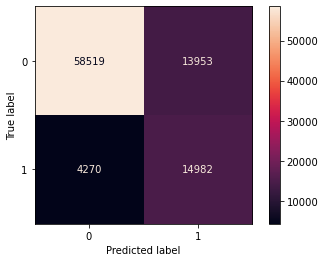

forest5 Model Training ROC Curve


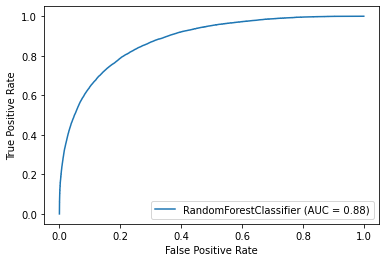

forest5 Model Test Confusion Matrix


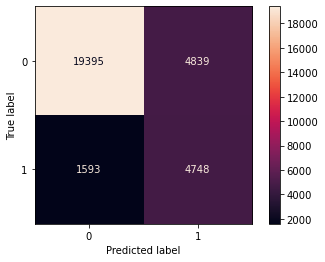

forest5 Model Test ROC Curve


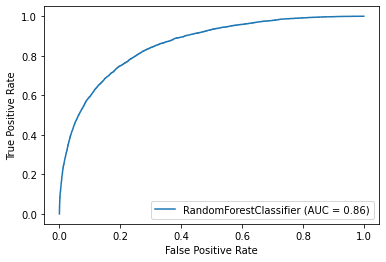

In [29]:
model_metrics(forest5, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'forest5')

In [31]:
forest6 = RandomForestClassifier(n_estimators=200, max_depth=13, min_samples_split=5, random_state=42)
forest6.fit(X_train_KNNI, np.ravel(y_train))

RandomForestClassifier(max_depth=13, min_samples_split=5, n_estimators=200,
                       random_state=42)


    forest6 Model Training Metrics:
    Accuracy Score: 0.875
    Recall Score: 0.463
    Precision Score: 0.885
    F1 Score: 0.608
    Cross Validation Score: 0.847
    ------
    forest6 Model Test Metrics:
    Accuracy Score: 0.85
    Recall Score: 0.391
    Precision Score: 0.772
    F1 Score: 0.519
    
forest6 Model Training Confusion Matrix


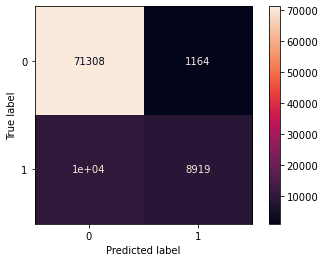

forest6 Model Training ROC Curve


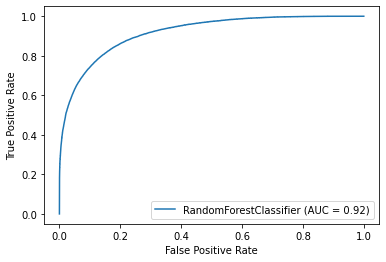

forest6 Model Test Confusion Matrix


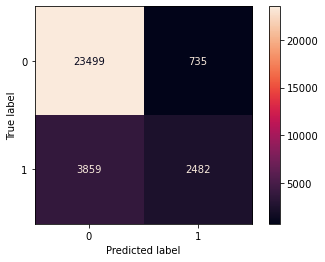

forest6 Model Test ROC Curve


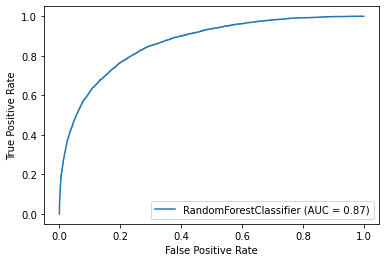

In [32]:
model_metrics(forest6, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'forest6')

In [34]:
forest7 = RandomForestClassifier(max_depth=13, min_samples_split=5, class_weight='balanced_subsample', random_state=42)
forest7.fit(X_train_KNNI, np.ravel(y_train))

RandomForestClassifier(class_weight='balanced_subsample', max_depth=13,
                       min_samples_split=5, random_state=42)


    forest7 Model Training Metrics:
    Accuracy Score: 0.844
    Recall Score: 0.809
    Precision Score: 0.594
    F1 Score: 0.685
    Cross Validation Score: 0.808
    ------
    forest7 Model Test Metrics:
    Accuracy Score: 0.808
    Recall Score: 0.725
    Precision Score: 0.528
    F1 Score: 0.611
    
forest7 Model Training Confusion Matrix


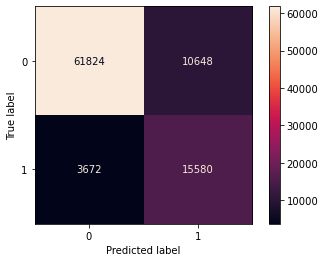

forest7 Model Training ROC Curve


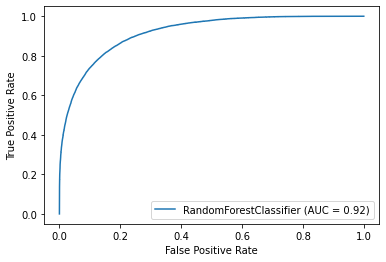

forest7 Model Test Confusion Matrix


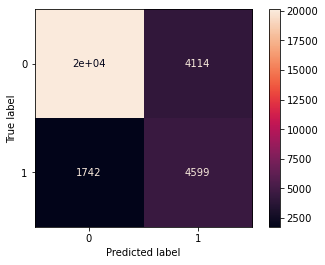

forest7 Model Test ROC Curve


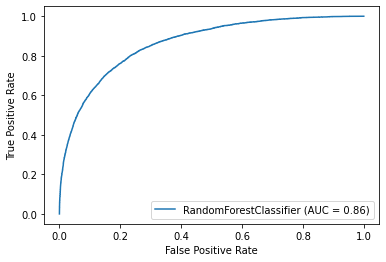

In [35]:
model_metrics(forest7, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'forest7')

In [46]:
forest8 = RandomForestClassifier(max_depth=13, max_samples=0.5, random_state=42)
forest8.fit(X_train_KNNI, np.ravel(y_train))

RandomForestClassifier(max_depth=13, max_samples=0.5, random_state=42)


    forest8 Model Training Metrics:
    Accuracy Score: 0.872
    Recall Score: 0.457
    Precision Score: 0.87
    F1 Score: 0.599
    Cross Validation Score: 0.847
    ------
    forest8 Model Test Metrics:
    Accuracy Score: 0.85
    Recall Score: 0.398
    Precision Score: 0.764
    F1 Score: 0.523
    
forest8 Model Training Confusion Matrix


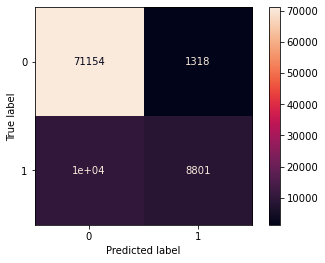

forest8 Model Training ROC Curve


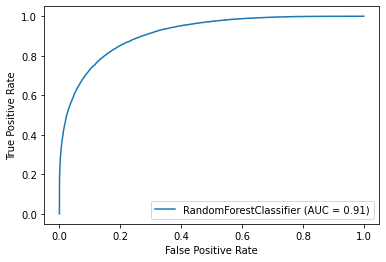

forest8 Model Test Confusion Matrix


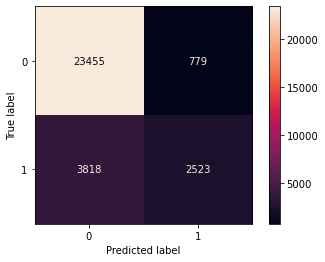

forest8 Model Test ROC Curve


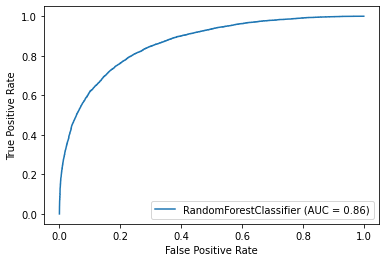

In [47]:
model_metrics(forest8, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'forest8')

In [48]:
forest9 = RandomForestClassifier(n_estimators=200, max_depth=13, max_samples=0.5, random_state=42, class_weight='balanced_subsample')
forest9.fit(X_train_KNNI, np.ravel(y_train))

RandomForestClassifier(class_weight='balanced_subsample', max_depth=13,
                       max_samples=0.5, n_estimators=200, random_state=42)


    forest9 Model Training Metrics:
    Accuracy Score: 0.845
    Recall Score: 0.779
    Precision Score: 0.6
    F1 Score: 0.678
    Cross Validation Score: 0.815
    ------
    forest9 Model Test Metrics:
    Accuracy Score: 0.816
    Recall Score: 0.705
    Precision Score: 0.543
    F1 Score: 0.614
    
forest9 Model Training Confusion Matrix


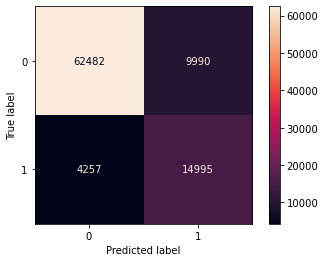

forest9 Model Training ROC Curve


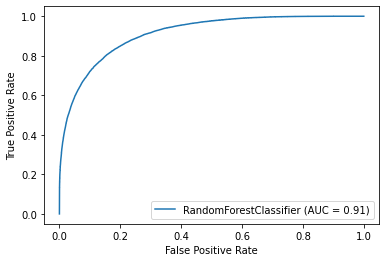

forest9 Model Test Confusion Matrix


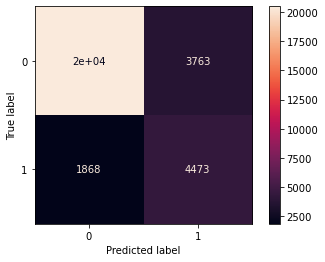

forest9 Model Test ROC Curve


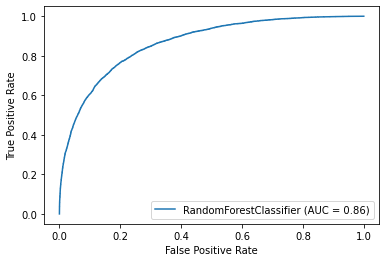

In [49]:
model_metrics(forest9, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'forest9')

In [63]:
forest10 = RandomForestClassifier(max_depth=13, random_state=42, min_samples_split=5)
forest10.fit(X_train_KNNI, np.ravel(y_train))

RandomForestClassifier(max_depth=13, min_samples_split=5, random_state=42)


    forest10 Model Training Metrics:
    Accuracy Score: 0.875
    Recall Score: 0.467
    Precision Score: 0.886
    F1 Score: 0.611
    Cross Validation Score: 0.847
    ------
    forest10 Model Test Metrics:
    Accuracy Score: 0.85
    Recall Score: 0.396
    Precision Score: 0.772
    F1 Score: 0.523
    
forest10 Model Training Confusion Matrix


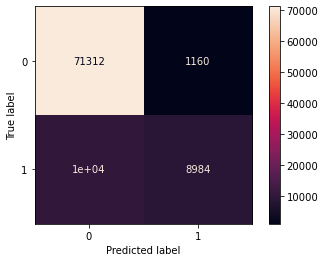

forest10 Model Training ROC Curve


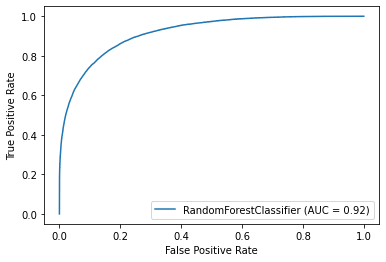

forest10 Model Test Confusion Matrix


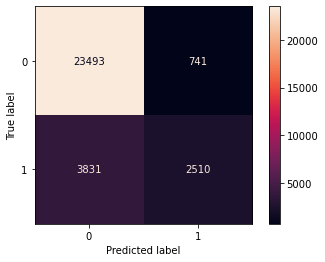

forest10 Model Test ROC Curve


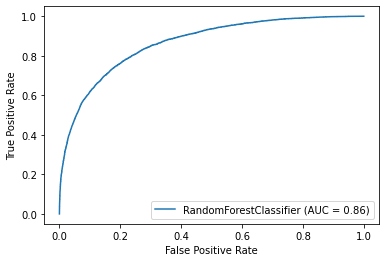

In [64]:
model_metrics(forest10, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'forest10')

In [66]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_KNNI, np.ravel(y_train))

GradientBoostingClassifier(random_state=42)


    gbc Model Training Metrics:
    Accuracy Score: 0.853
    Recall Score: 0.458
    Precision Score: 0.744
    F1 Score: 0.567
    Cross Validation Score: 0.85
    ------
    gbc Model Test Metrics:
    Accuracy Score: 0.852
    Recall Score: 0.46
    Precision Score: 0.729
    F1 Score: 0.564
    
gbc Model Training Confusion Matrix


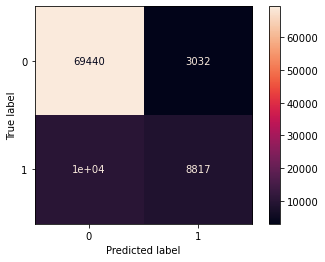

gbc Model Training ROC Curve


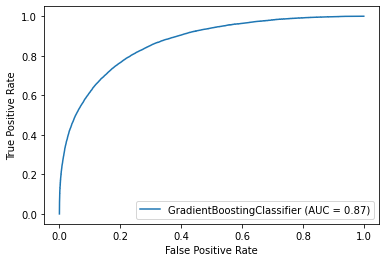

gbc Model Test Confusion Matrix


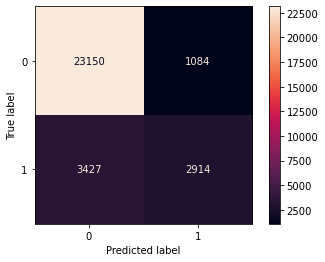

gbc Model Test ROC Curve


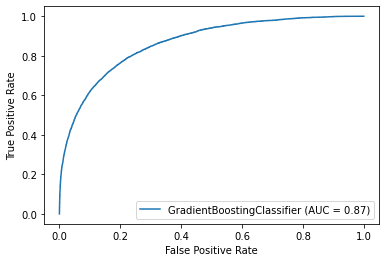

In [67]:
model_metrics(gbc, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'gbc')

In [70]:
y_pred = gbc.predict(X_test_KNNI)
balanced_accuracy_score(y_test, y_pred)

0.7074092115879531

In [77]:
gbc = GradientBoostingClassifier(min_samples_split=5, random_state=42)
param_grid = {'learning_rate': [0.1, 0.2, 0.4]}
gbc_grid = GridSearchCV(gbc, param_grid, verbose=2)
gbc_grid.fit(X_train_KNNI, np.ravel(y_train))
gbc_grid.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] learning_rate=0.1 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ learning_rate=0.1, total=  24.8s
[CV] learning_rate=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s remaining:    0.0s


[CV] ................................ learning_rate=0.1, total=  24.9s
[CV] learning_rate=0.1 ...............................................
[CV] ................................ learning_rate=0.1, total=  24.6s
[CV] learning_rate=0.1 ...............................................
[CV] ................................ learning_rate=0.1, total=  24.7s
[CV] learning_rate=0.1 ...............................................
[CV] ................................ learning_rate=0.1, total=  24.6s
[CV] learning_rate=0.2 ...............................................
[CV] ................................ learning_rate=0.2, total=  24.3s
[CV] learning_rate=0.2 ...............................................
[CV] ................................ learning_rate=0.2, total=  24.2s
[CV] learning_rate=0.2 ...............................................
[CV] ................................ learning_rate=0.2, total=  25.3s
[CV] learning_rate=0.2 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  6.1min finished


{'learning_rate': 0.4}

In [75]:
gbc2 = GradientBoostingClassifier(max_depth=3, min_samples_split=5, random_state=42)
gbc2.fit(X_train_KNNI, np.ravel(y_train))

GradientBoostingClassifier(min_samples_split=5, random_state=42)


    gbc2 Model Training Metrics:
    Accuracy Score: 0.853
    Recall Score: 0.458
    Precision Score: 0.744
    F1 Score: 0.567
    Cross Validation Score: 0.85
    ------
    gbc2 Model Test Metrics:
    Accuracy Score: 0.852
    Recall Score: 0.46
    Precision Score: 0.729
    F1 Score: 0.564
    
gbc2 Model Training Confusion Matrix


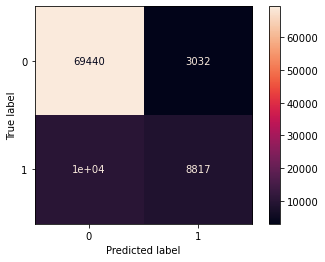

gbc2 Model Training ROC Curve


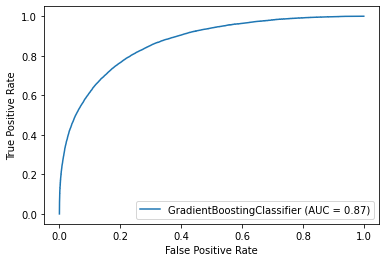

gbc2 Model Test Confusion Matrix


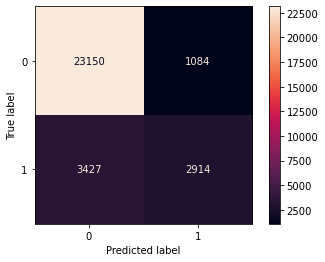

gbc2 Model Test ROC Curve


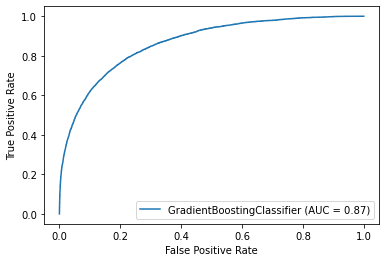

In [76]:
model_metrics(gbc2, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'gbc2')

In [78]:
gbc3 = GradientBoostingClassifier(max_depth=3, learning_rate=0.4, random_state=42)
gbc3.fit(X_train_KNNI, np.ravel(y_train))

GradientBoostingClassifier(learning_rate=0.4, random_state=42)


    gbc3 Model Training Metrics:
    Accuracy Score: 0.863
    Recall Score: 0.513
    Precision Score: 0.756
    F1 Score: 0.611
    Cross Validation Score: 0.854
    ------
    gbc3 Model Test Metrics:
    Accuracy Score: 0.856
    Recall Score: 0.495
    Precision Score: 0.726
    F1 Score: 0.589
    
gbc3 Model Training Confusion Matrix


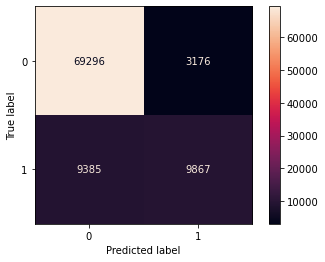

gbc3 Model Training ROC Curve


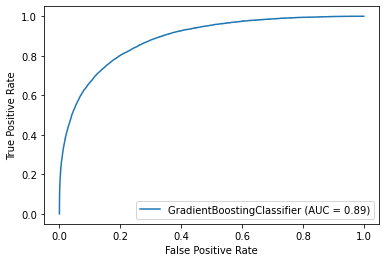

gbc3 Model Test Confusion Matrix


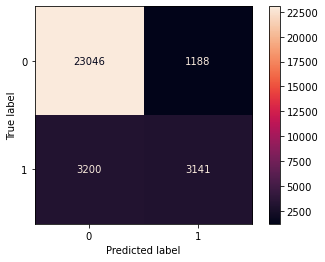

gbc3 Model Test ROC Curve


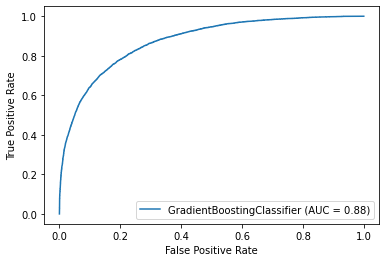

In [79]:
model_metrics(gbc3, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'gbc3')

In [80]:
gbc = GradientBoostingClassifier(random_state=42)
param_grid = {'learning_rate': [0.4, 0.6, 0.8]}
gbc_grid = GridSearchCV(gbc, param_grid, verbose=2)
gbc_grid.fit(X_train_KNNI, np.ravel(y_train))
gbc_grid.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] learning_rate=0.4 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ learning_rate=0.4, total=  25.6s
[CV] learning_rate=0.4 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s remaining:    0.0s


[CV] ................................ learning_rate=0.4, total=  25.1s
[CV] learning_rate=0.4 ...............................................
[CV] ................................ learning_rate=0.4, total=  25.2s
[CV] learning_rate=0.4 ...............................................
[CV] ................................ learning_rate=0.4, total=  25.4s
[CV] learning_rate=0.4 ...............................................
[CV] ................................ learning_rate=0.4, total=  25.0s
[CV] learning_rate=0.6 ...............................................
[CV] ................................ learning_rate=0.6, total=  25.5s
[CV] learning_rate=0.6 ...............................................
[CV] ................................ learning_rate=0.6, total=  25.1s
[CV] learning_rate=0.6 ...............................................
[CV] ................................ learning_rate=0.6, total=  25.7s
[CV] learning_rate=0.6 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  6.3min finished


{'learning_rate': 0.6}

In [81]:
gbc4 = GradientBoostingClassifier(max_depth=3, learning_rate=0.6, random_state=42)
gbc4.fit(X_train_KNNI, np.ravel(y_train))

GradientBoostingClassifier(learning_rate=0.6, random_state=42)


    gbc4 Model Training Metrics:
    Accuracy Score: 0.868
    Recall Score: 0.534
    Precision Score: 0.765
    F1 Score: 0.629
    Cross Validation Score: 0.855
    ------
    gbc4 Model Test Metrics:
    Accuracy Score: 0.857
    Recall Score: 0.508
    Precision Score: 0.718
    F1 Score: 0.595
    
gbc4 Model Training Confusion Matrix


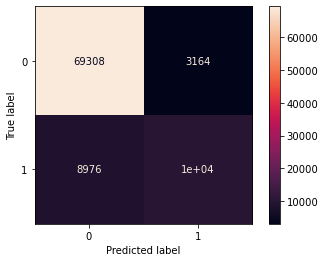

gbc4 Model Training ROC Curve


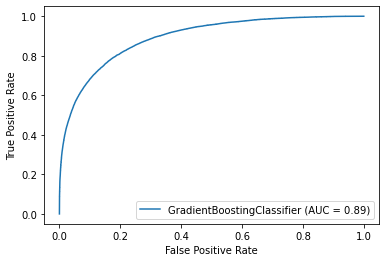

gbc4 Model Test Confusion Matrix


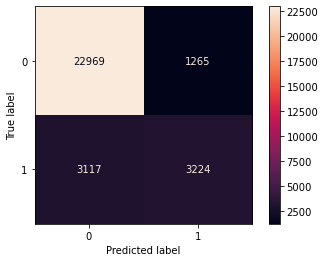

gbc4 Model Test ROC Curve


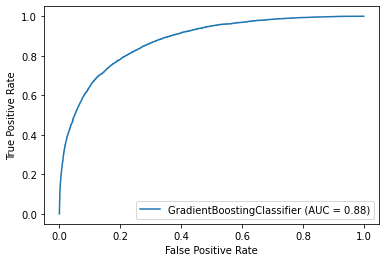

In [82]:
model_metrics(gbc4, X_train_KNNI, np.ravel(y_train), X_test_KNNI, y_test, 'gbc4')

In [100]:
gbc4.feature_importances_

array([1.12184267e-02, 9.46295817e-03, 8.30103805e-02, 5.56632619e-02,
       8.12334629e-02, 5.83806638e-03, 9.98168323e-03, 5.87819800e-03,
       4.93649165e-01, 1.29360564e-02, 9.22580728e-02, 1.23973997e-03,
       2.94061643e-02, 6.49736179e-03, 1.59865861e-02, 7.93577819e-04,
       8.44233327e-04, 5.06659417e-03, 9.70336658e-04, 8.90789024e-05,
       1.42942313e-03, 8.26671522e-04, 1.77762254e-04, 2.71618531e-03,
       7.46889629e-04, 1.05528807e-03, 3.06363427e-04, 1.84989126e-03,
       7.34117899e-04, 6.14498853e-04, 8.08094103e-04, 1.65079245e-03,
       8.75096481e-05, 9.41617480e-04, 8.80046900e-05, 3.16655390e-04,
       0.00000000e+00, 0.00000000e+00, 6.69604291e-04, 1.02873415e-02,
       6.74354869e-04, 0.00000000e+00, 2.69017785e-03, 1.46192395e-03,
       2.02662585e-04, 3.45969744e-04, 2.26606826e-04, 2.92438516e-03,
       8.64886764e-04, 1.13141020e-03, 9.35355619e-04, 8.55918143e-04,
       1.01542191e-03, 1.92361460e-03, 4.32193266e-04, 1.10056956e-03,
      

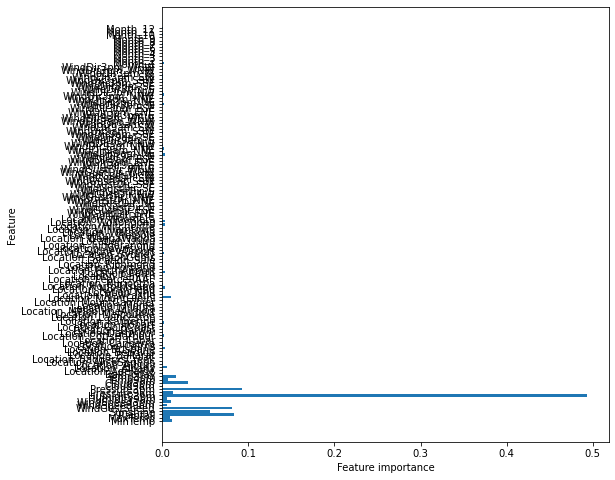

In [102]:
def plot_feature_importances(model):
    n_features = X_train_KNNI.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_KNNI.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(gbc4)

In [105]:
feature_names = np.array(X_train_KNNI.columns)
feature_names

array(['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Location_Adelaide', 'Location_Albany',
       'Location_Albury', 'Location_AliceSprings',
       'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo',
       'Location_Brisbane', 'Location_Cairns', 'Location_Canberra',
       'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor',
       'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart',
       'Location_Katherine', 'Location_Launceston', 'Location_Melbourne',
       'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree',
       'Location_MountGambier', 'Location_MountGinini',
       'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead',
       'Location_NorfolkIsland', 'Location_Nuriootpa',
       'Location_PearceRAAF', 'Location_Penrith', 'Location_

In [111]:
features = dict(zip(feature_names, gbc4.feature_importances_))

In [112]:
features

{'MinTemp': 0.011218426692884111,
 'MaxTemp': 0.009462958174422756,
 'Rainfall': 0.08301038049770904,
 'Sunshine': 0.055663261929571904,
 'WindGustSpeed': 0.08123346288379596,
 'WindSpeed9am': 0.005838066380565858,
 'WindSpeed3pm': 0.009981683226592637,
 'Humidity9am': 0.005878197998956819,
 'Humidity3pm': 0.4936491646119233,
 'Pressure9am': 0.012936056368991216,
 'Pressure3pm': 0.09225807281533295,
 'Cloud9am': 0.001239739974406474,
 'Cloud3pm': 0.029406164335660824,
 'Temp9am': 0.006497361792858626,
 'Temp3pm': 0.01598658612922889,
 'RainToday': 0.0007935778191223295,
 'Location_Adelaide': 0.0008442333267732415,
 'Location_Albany': 0.005066594165850482,
 'Location_Albury': 0.0009703366578284856,
 'Location_AliceSprings': 8.907890240311044e-05,
 'Location_BadgerysCreek': 0.0014294231324846192,
 'Location_Ballarat': 0.0008266715220026828,
 'Location_Bendigo': 0.00017776225439990081,
 'Location_Brisbane': 0.0027161853122402786,
 'Location_Cairns': 0.0007468896294575939,
 'Location_Canbe

In [118]:
sorted_features = {k: v for k, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}

In [120]:
sorted_features

TypeError: unhashable type: 'slice'

In [126]:
first_10_features = list(sorted_features.items())[:11]

In [127]:
first_10_features

[('Humidity3pm', 0.4936491646119233),
 ('Pressure3pm', 0.09225807281533295),
 ('Rainfall', 0.08301038049770904),
 ('WindGustSpeed', 0.08123346288379596),
 ('Sunshine', 0.055663261929571904),
 ('Cloud3pm', 0.029406164335660824),
 ('Temp3pm', 0.01598658612922889),
 ('Pressure9am', 0.012936056368991216),
 ('MinTemp', 0.011218426692884111),
 ('Location_MountGinini', 0.010287341487482548),
 ('WindSpeed3pm', 0.009981683226592637)]

In [129]:
x, y = zip(*first_10_features)

<BarContainer object of 11 artists>

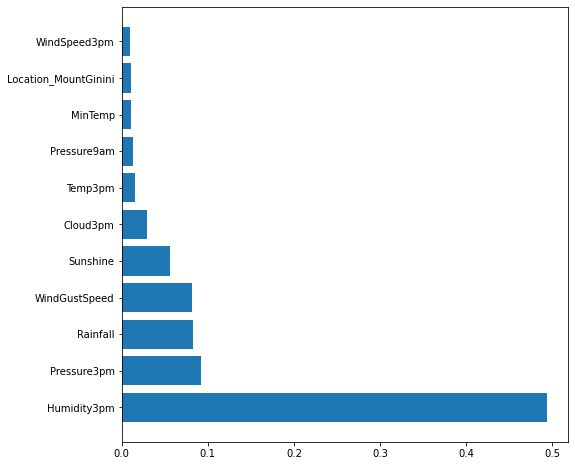

In [137]:
plt.figure(figsize=(8,8))
plt.barh(x, y, align='center') 